In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
font = {'size'   : 12}

matplotlib.rc('font', **font)
# matplotlib.style.use('fivethirtye')
%matplotlib inline

import sklearn.metrics as mt
matplotlib.style.available

['grayscale',
 'ggplot',
 'dark_background',
 'seaborn-poster',
 'seaborn-dark-palette',
 'seaborn-muted',
 'seaborn-white',
 'seaborn-talk',
 'seaborn-whitegrid',
 'seaborn-dark',
 'seaborn-notebook',
 'fivethirtyeight',
 'classic',
 'seaborn-bright',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn',
 'seaborn-ticks',
 'seaborn-deep',
 'seaborn-darkgrid',
 '_classic_test',
 'bmh',
 'seaborn-colorblind']

# Utility Functions

In [2]:
def baseline_perf_compute(model_path, model_name):
    baseline_perf = {}
    test_scores_loso = np.load(model_path+"leave_one_subject/"+model_name+"_Test_Scores.npz")['arr_0']
    test_scores_personalized = np.load(model_path+"personalized/"+model_name+"_Test_Scores.npz")['arr_0']
    test_scores_user_calibrated = np.load(model_path+"user_calibrated/"+model_name+"0.6_Test_Scores.npz")['arr_0']
    baseline_perf['Leave-one-subject'] = [np.mean(test_scores_loso), np.std(test_scores_loso)/np.sqrt(len(test_scores_loso))]
    baseline_perf['Personalized'] = [np.mean(test_scores_personalized), np.std(test_scores_personalized)/np.sqrt(len(test_scores_personalized.reshape(-1)))]
    baseline_perf['User-calibrated'] = [np.mean(test_scores_user_calibrated), np.std(test_scores_user_calibrated)/np.sqrt(len(test_scores_user_calibrated.reshape(-1)))]
    
    return pd.DataFrame(baseline_perf)


def deep_perf_compute(model_path):
    model_perf = {}
    loso_path = "./leave_one_subject/gest_set_1/"
    personalized_path = "./personalized_cv/gest_set_1/"
    user_calibrated_path = "./user_split_cv/gest_set_1/"
    test_scores_loso = np.load(loso_path+model_path+"_Test_Scores.npz")['arr_0'][:,1]
    test_scores_personalized = np.load(personalized_path+model_path+"_Test_Scores.npz")['arr_0'][:,:,1]
    test_scores_user_calibrated = np.load(user_calibrated_path + model_path + "0.6_Test_Scores.npz")['arr_0'][:,:,1]
    model_perf['Leave-one-subject'] = [np.mean(test_scores_loso), np.std(test_scores_loso)/np.sqrt(len(test_scores_loso))]
    model_perf['Personalized'] = [np.mean(test_scores_personalized), np.std(test_scores_personalized)/np.sqrt(len(test_scores_personalized))]
    model_perf['User-calibrated'] = [np.mean(test_scores_user_calibrated), np.std(test_scores_user_calibrated)/np.sqrt(len(test_scores_user_calibrated))]
    
    return pd.DataFrame(model_perf)


def baseline_ir_doppler_perf(model_path, model_name):
    perf = {}
    ir = np.load(model_path+"ir/_Test_Scores.npz")['arr_0']
    doppler = np.load(model_path+"doppler/_Test_Scores.npz")['arr_0']
    combined = np.load(model_path+"leave_one_subject/"+model_name+"_Test_Scores.npz")['arr_0']
    
    perf['Only-IR'] = [np.mean(ir), np.std(ir)/np.sqrt(len(ir))]
    perf['Only-Doppler'] = [np.mean(doppler), np.std(doppler)/np.sqrt(len(doppler))]
    perf['Combined-Sensor'] = [np.mean(combined), np.std(combined)/np.sqrt(len(combined))]
    
    return pd.DataFrame(perf)

def deep_ir_doppler_perf(model_path):
    perf = {}
    ir = np.load("leave_one_subject/ir/"+model_path+"_Test_Scores.npz")['arr_0'][:,1]
    doppler = np.load("leave_one_subject/doppler/"+model_path+"_Test_Scores.npz")['arr_0'][:,1]
    combined = np.load("leave_one_subject/gest_set_1/"+model_path+"_Test_Scores.npz")['arr_0'][:,1]
    
    perf['Only-IR'] = [np.mean(ir), np.std(ir)/np.sqrt(len(ir))]
    perf['Only-Doppler'] = [np.mean(doppler), np.std(doppler)/np.sqrt(len(doppler))]
    perf['Combined-Sensor'] = [np.mean(combined), np.std(combined)/np.sqrt(len(combined))]
    
    return pd.DataFrame(perf)


def user_tpr(y_true, y_pred):
    tpr_user = {}
    mean_acc = []
    for idx, (y_true_user, y_pred_user) in enumerate(zip(y_true, y_pred)):
        total_samples = len(y_true_user)
        conf_mat = mt.confusion_matrix(y_true_user, y_pred_user)
        per_class_acc = np.true_divide(conf_mat.diagonal(), np.sum(conf_mat, axis=1))
        user_name = idx
        tpr_user[user_name] = [np.nanmean(per_class_acc), np.nanstd(per_class_acc) / np.sqrt(total_samples)]
        mean_acc.append(np.nanmean(per_class_acc))
    tpr_user['Average across users'] = [np.mean(mean_acc), np.std(mean_acc)/np.sqrt(len(mean_acc))]
    tpr_df = pd.DataFrame(tpr_user)
    return tpr_df


def get_personalized_tpr(model_path):
    cv_y_pred = np.load(model_path+"_Predictions.npz")['arr_0']
    cv_y_true = np.load(model_path+"_Truth.npz")['arr_0']
    y_pred, y_true = [], []
    for idx, (a,b) in enumerate(zip(cv_y_pred, cv_y_true)):
        y_pred.append(flat_list_of_array(a))
        y_true.append(flat_list_of_array(b))
    model_tpr = user_tpr(y_true, y_pred)
    
    return model_tpr, y_true, y_pred

def plot_perf(perf_df, x_labels, total_width=0.8, title_text="Baseline Models",
                  file_path="./figure/", figsize=(20,8)):
    fig, ax = plt.subplots(figsize=figsize)
    N = len(x_labels)
    ind = np.arange(N)
    total_bar = perf_df.shape[0] / 2
    ind_width = total_width / total_bar
    alteration = np.arange(-(total_width / 2), total_width / 2, ind_width)
    for i, item in enumerate(perf_df.groupby(level=0)):
        df = item[1]
        ax.bar(left=ind + alteration[i], height=df.iloc[0, :-1],
               yerr=df.iloc[1, :-1], width=ind_width, label=item[0])

    ax.set_xticks(ind - ind_width / total_bar)
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1.1, 0.1))
    ax.set_ylabel("Average True Positive Rate", fontsize=20)
    ax.set_title(title_text, fontsize=25)
    plt.legend()
    plt.savefig(file_path + '_Performance_Comparison.png', dpi=500)
    

def plot_confusion_matrix(conf_mat, target_names, title_text='Confusion Matrix', title_text_2='Accuracy',
                          file_path="./figure/"):
    plt.figure(figsize=(25, 8))
    sns.set(font_scale=1.5)
    acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
    # support = np.sum(conf_mat, axis=1).reshape(len(target_names), 1)
    conf_mat = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]
    # conf_mat = np.append(conf_mat, support, axis=1)
    mask = conf_mat == 0
    x_labels = np.append(target_names, 'Support')
    with sns.axes_style('white'):
        sns.heatmap(conf_mat, annot=True, fmt='.2f', vmin=0, vmax=1,
                    xticklabels=x_labels, yticklabels=target_names,
                    mask=mask)
    plt.title(title_text, fontsize=25)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual Class', fontsize=20)
    plt.yticks(rotation=0)
    plt.savefig(file_path+"_Confusion_Matrix.png", dpi=500)


def classification_report(y_true, y_pred, target_names, title_text, file_path):
    precision, recall, f1, support = mt.precision_recall_fscore_support(y_true, y_pred)
    conf_mat = mt.confusion_matrix(y_true=y_true, y_pred=y_pred)
    per_class_acc = conf_mat.diagonal() / np.sum(conf_mat, axis=1)

    report_df = pd.DataFrame([precision, recall, f1, per_class_acc, support], columns=target_names).T
    report_df.columns = ['Precision', 'Recall', 'F1_Score', 'Accuracy', 'Support']

    plot_confusion_matrix(conf_mat, target_names, title_text, file_path=file_path)
    return report_df

def flat_list_of_array(l):
    return np.concatenate(l).ravel()


def training_curve_user_calibrated(model_path, model_name):
    # Training Curves
    train_size_percent=[0.1,0.2,0.3,0.4,0.5,0.6]
    test_perf_df = pd.DataFrame()
    for train_size in train_size_percent:
        test_scores = np.load(model_path+str(train_size)+"_Test_Scores.npz")['arr_0']
        if test_scores.ndim > 2:
            test_acc_mean = np.mean(test_scores[:,:,1])
            test_acc_std_err = np.std(test_scores[:,:,1])/np.sqrt((test_scores.shape[0]*test_scores.shape[1]))
        else:
            test_acc_mean = np.mean(test_scores)
            test_acc_std_err = np.std(test_scores)/np.sqrt((test_scores.shape[0]*test_scores.shape[1]))
            
        
        test_perf_df[train_size] = [test_acc_mean, test_acc_std_err]
    test_perf_df['Label'] = model_name
    return test_perf_df

def plot_training_curve(test_perf_df, title_text, file_path="./figure/"):
    fig, ax = plt.subplots(figsize=(20,8))
    for item in test_perf_df.groupby(level=0):
        df = item[1]
        ax.errorbar(x=df.columns[:-1], y=df.iloc[0,:-1],yerr=df.iloc[1,:-1], fmt='--o', label=item[0])
    ax.set_ylabel("Accuracy", fontsize=20)
    ax.set_xlabel("Training Size", fontsize=20)
    ax.set_title(title_text, fontsize=25)
    plt.legend()
    plt.savefig(file_path+"_Training_Curve.png", dpi=500)

# Grid Search FFT Parameters

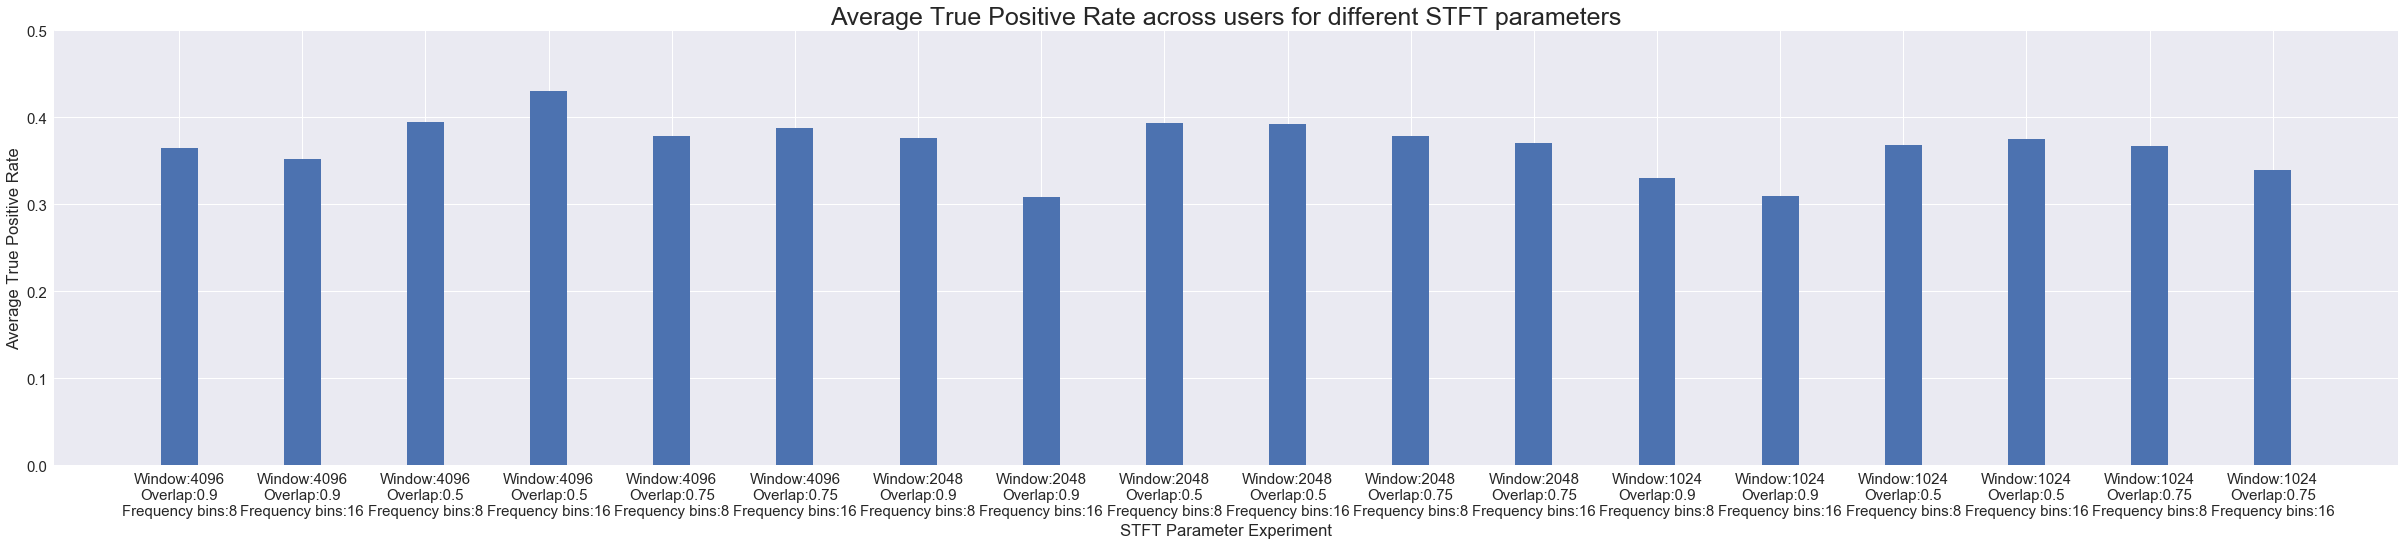

In [21]:
nfft_try = [int(4096), int(2048), int(1024)]
overlap_try = [0.9, 0.5, 0.75]
brange_try = [8,16]
filenames = []
gridSearch_path = "./gridSearch/fft_params/"
xtick_labels = []
for nfft_val in nfft_try:
    for overlap_val in overlap_try:
        for brange_val in brange_try:
            # Define file name to store results
            filenames.append("Exp_"+str(nfft_val)+"_"+str(overlap_val)+"_"+str(brange_val))
            xtick_labels.append("Window:"+str(nfft_val)+"\nOverlap:"+str(overlap_val)+"\nFrequency bins:"+str(brange_val))
accuracy = dict()
for idx, fname in enumerate(filenames):
    y_pred = flat_list_of_array(np.load(gridSearch_path+fname+"_Predictions.npz")['arr_0'])
    y_true = flat_list_of_array(np.load(gridSearch_path+fname+"_Truth.npz")['arr_0'])
    acc = mt.accuracy_score(y_true=y_true, y_pred=y_pred)
    accuracy[idx] = acc
    
plt.figure(figsize=(42,8))
plt.bar(range(len(accuracy)), accuracy.values(), align='center', width=0.3)
plt.xticks(range(len(accuracy)), xtick_labels)
plt.yticks(np.arange(0,0.6,0.1))
plt.title("Average True Positive Rate across users for different STFT parameters", fontsize=25)
plt.xlabel("STFT Parameter Experiment")
plt.ylabel("Average True Positive Rate")
plt.savefig("./figure/FFT_GridSearch.png", dpi=300)

In [4]:
print("Window_Size:\n "+str(nfft_val)+"Overlap:\n "+str(overlap_val)+"Frequency Bin: "+str(brange_val))

Window_Size:
 1024Overlap:
 0.75Frequency Bin: 16


# Performance of all Models

## Across Cross-Validation Strategies

Leave-one-subject  Personalized  User-calibrated  \
Random Forest 0           0.389269      0.240856         0.403159   
              1           0.018284      0.011989         0.012081   
SVM           0           0.196520      0.117456         0.226328   
              1           0.016838      0.009205         0.008862   
MLP           0           0.182242      0.066964         0.179459   
              1           0.017610      0.005511         0.011016   
Model 1       0           0.358653      0.231278         0.378620   
              1           0.021847      0.021639         0.027357   
Model 2       0           0.445890      0.219513         0.492501   
              1           0.026979      0.024769         0.034110   
Model 3       0           0.454426      0.241245         0.512919   
              1           0.023109      0.030949         0.032121   
Model 4       0           0.415470      0.193339         0.432931   
              1           0.025994      0.027797         0.035919   

                         Model  
Random Forest 0  Random Forest  
              1  Random Forest  
SVM           0            SVM  
              1            SVM  
MLP           0            MLP  
              1            MLP  
Model 1       0        Model 1  
              1        Model 1  
Model 2       0        Model 2  
              1        Model 2  
Model 3       0        Model 3  
              1        Model 3  
Model 4       0        Model 4  
              1        Model 4

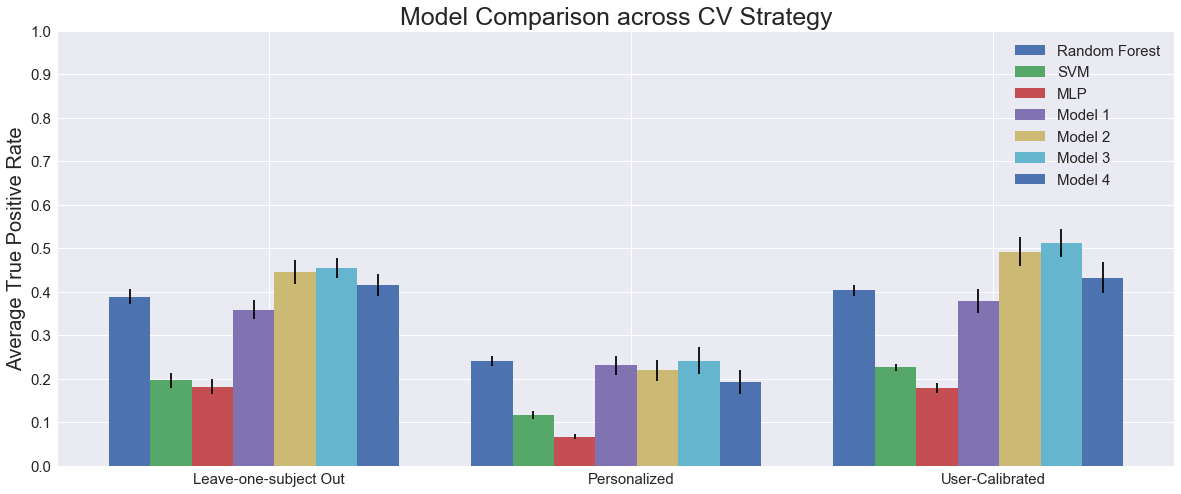

In [5]:
# Random Forest
rf_path = "./baseline_models/rf/"
rf_perf = baseline_perf_compute(rf_path, 'rf')
# SVM
svm_path = "./baseline_models/svm/"
svm_perf = baseline_perf_compute(svm_path, 'svm')
# MLP
mlp_path = "./baseline_models/mlp/"
mlp_perf = baseline_perf_compute(mlp_path, 'mlp')

rf_perf['Model'] = 'Random Forest'
svm_perf['Model'] = 'SVM'
mlp_perf['Model'] = 'MLP'

model1_path = "split_model_1/Model"
model1_perf = deep_perf_compute(model1_path)

model2_path = "split_model_2/Model"
model2_perf = deep_perf_compute(model2_path)

model3_path = "split_model_3/Model"
model3_perf = deep_perf_compute(model3_path)

model4_path = "split_model_4/Model"
model4_perf = deep_perf_compute(model4_path)

model1_perf['Model'] = 'Model 1'
model2_perf['Model'] = 'Model 2'
model3_perf['Model'] = 'Model 3'
model4_perf['Model'] = 'Model 4'


perf = pd.concat([rf_perf, svm_perf, mlp_perf, model1_perf, model2_perf, model3_perf, model4_perf], keys=['Random Forest','SVM','MLP', 'Model 1', 'Model 2', 'Model 3', 'Model 4'])
plot_perf(perf, ['Leave-one-subject Out','Personalized','User-Calibrated'], title_text="Model Comparison across CV Strategy",
             file_path = "./figure/CV")
perf

## Individual sensor and their combination

Combined-Sensor  Only-Doppler   Only-IR          Model
Random Forest 0         0.389269      0.137047  0.329219  Random Forest
              1         0.018284      0.016009  0.017702  Random Forest
SVM           0         0.196520      0.053768  0.350312            SVM
              1         0.016838      0.000986  0.013176            SVM
MLP           0         0.182242      0.113768  0.252790            MLP
              1         0.017610      0.018620  0.014505            MLP
Model 1       0         0.358653      0.116794  0.320867        Model 1
              1         0.021847      0.016412  0.023332        Model 1
Model 2       0         0.454426      0.102704  0.346757        Model 2
              1         0.023109      0.008507  0.017837        Model 2
Model 3       0         0.454426      0.102704  0.346757        Model 3
              1         0.023109      0.008507  0.017837        Model 3
Model 4       0         0.415470      0.137676  0.338274        Model 4
              1         0.025994      0.013733  0.020327        Model 4

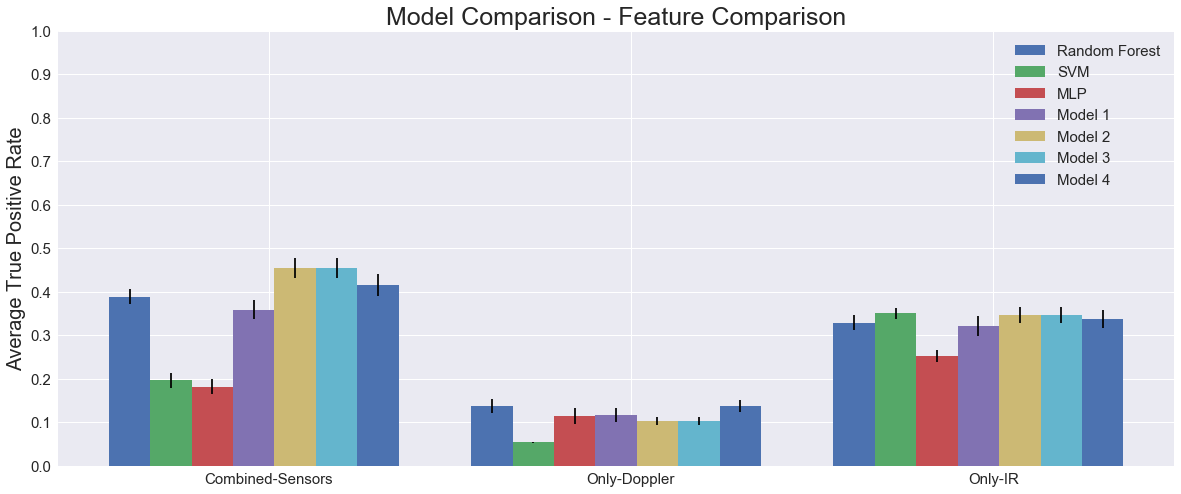

In [6]:
# Random Forest
rf_ir_doppler = baseline_ir_doppler_perf(rf_path, 'rf')
# SVM
svm_ir_doppler = baseline_ir_doppler_perf(svm_path, 'svm')
# MLP
mlp_ir_doppler = baseline_ir_doppler_perf(mlp_path, 'mlp')

rf_ir_doppler['Model'] = 'Random Forest'
svm_ir_doppler['Model'] = 'SVM'
mlp_ir_doppler['Model'] = 'MLP'

model1_ir_doppler = deep_ir_doppler_perf(model1_path)
model2_ir_doppler = deep_ir_doppler_perf(model3_path)
model3_ir_doppler = deep_ir_doppler_perf(model3_path)
model4_ir_doppler = deep_ir_doppler_perf(model4_path)

model1_ir_doppler['Model'] = 'Model 1'
model2_ir_doppler['Model'] = 'Model 2'
model3_ir_doppler['Model'] = 'Model 3'
model4_ir_doppler['Model'] = 'Model 4'


perf = pd.concat([rf_ir_doppler, svm_ir_doppler, mlp_ir_doppler, model1_ir_doppler, model2_ir_doppler, model3_ir_doppler, model4_ir_doppler], keys=['Random Forest','SVM','MLP', 'Model 1', 'Model 2', 'Model 3', 'Model 4'])
plot_perf(perf, ['Combined-Sensors','Only-Doppler', 'Only-IR'], title_text="Model Comparison - Feature Comparison",
             file_path = "./figure/Feature")
perf

# Best Model

## Leave One Subject Out

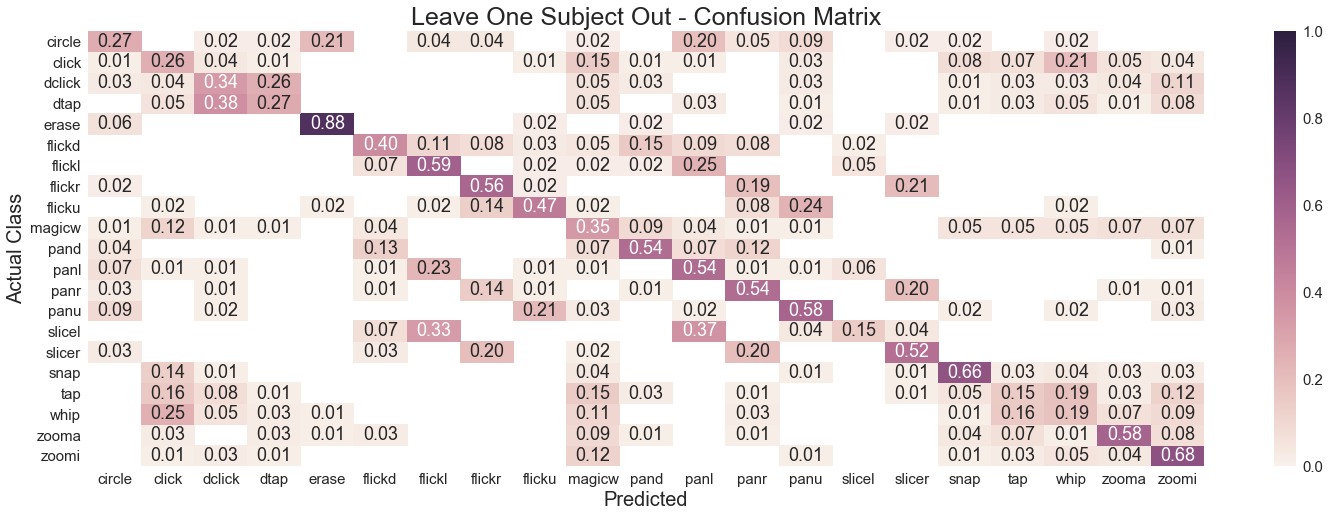

In [7]:
best_model_path = "./leave_one_subject/gest_set_1/split_model_3/Model"

y_pred = np.load(best_model_path+"_Predictions.npz")['arr_0']
y_true = np.load(best_model_path+"_Truth.npz")['arr_0']
class_names = np.load(best_model_path+"_Class_Names.npz")['arr_0']
best_model_loso_perf = classification_report(y_true = flat_list_of_array(y_true), 
                                   y_pred = flat_list_of_array(y_pred), 
                                   target_names = class_names,
                                   title_text = "Leave One Subject Out - Confusion Matrix",
                                   file_path = "./figure/BestModel_Loso")
# Compute per gesture per user true positive rate
best_model_loso_tpr = user_tpr(y_true, y_pred)

## Personalized Model

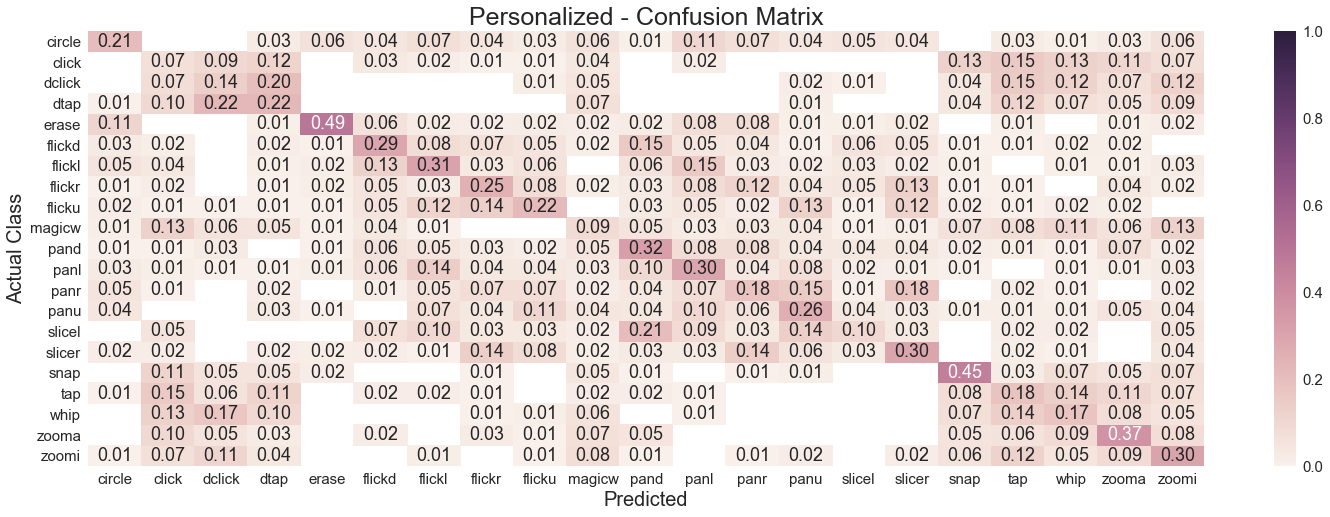

In [8]:
best_model_path = "./personalized_cv/gest_set_1/split_model_3/Model"
class_names = np.load(best_model_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
best_model_personalized_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(best_model_path)
best_model_personalized_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "Personalized - Confusion Matrix",
                                   file_path = "./figure/BestModel_Personalized")

## User-Calibrated

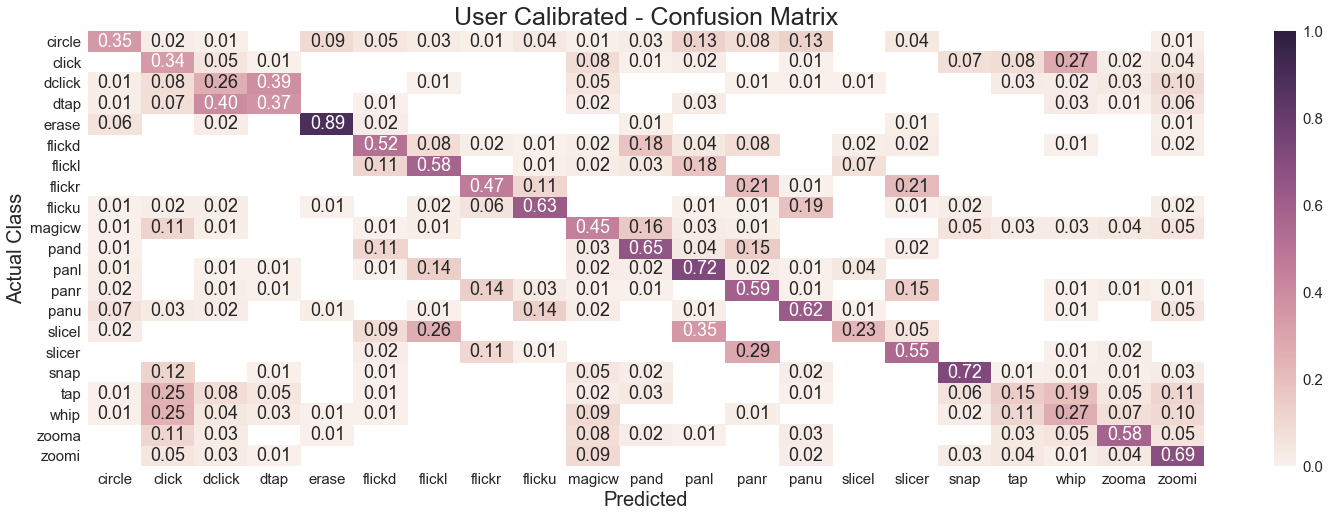

In [9]:
best_model_path = "./user_split_cv/gest_set_1/split_model_3/Model0.6"
class_names = np.load(best_model_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
best_model_user_calibrated_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(best_model_path)
best_model_user_calibrated_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "User Calibrated - Confusion Matrix",
                                   file_path = "./figure/BestModel_UserCalibrated")

## Comparison across CV

0         1         2         3         4  \
Leave-One-Subject-Out 0  0.391667  0.325397  0.392857  0.361395  0.335714   
                      1  0.048579  0.027716  0.031402  0.020197  0.026787   
Personalized          0  0.093095  0.099206  0.183201  0.223016  0.190212   
                      1  0.012562  0.010465  0.013068  0.009305  0.015639   
User-Calibrated       0  0.509206  0.481104  0.462358  0.348413  0.315344   
                      1  0.032955  0.025593  0.019013  0.013494  0.018267   

                                5         6         7         8         9  \
Leave-One-Subject-Out 0  0.548186  0.451754  0.539683  0.542063  0.505556   
                      1  0.022550  0.041822  0.033281  0.035769  0.027417   
Personalized          0  0.177778  0.237364  0.402778  0.314286  0.157143   
                      1  0.014129  0.022600  0.019549  0.020152  0.015822   
User-Calibrated       0  0.563492  0.427652  0.682313  0.628571  0.552381   
                      1  0.016491  0.030884  0.024202  0.021837  0.023767   

                               10        11        12  Average across users  \
Leave-One-Subject-Out 0  0.462619  0.530000  0.488095              0.451922   
                      1  0.027255  0.036483  0.021486              0.021800   
Personalized          0  0.259322  0.400000  0.341702              0.236854   
                      1  0.013745  0.021331  0.014300              0.027342   
User-Calibrated       0  0.473731  0.585000  0.530945              0.504655   
                      1  0.018991  0.021711  0.016883              0.027661   

                                   cv_strategy  
Leave-One-Subject-Out 0  Leave-One-Subject-Out  
                      1  Leave-One-Subject-Out  
Personalized          0           Personalized  
                      1           Personalized  
User-Calibrated       0        User-Calibrated  
                      1        User-Calibrated

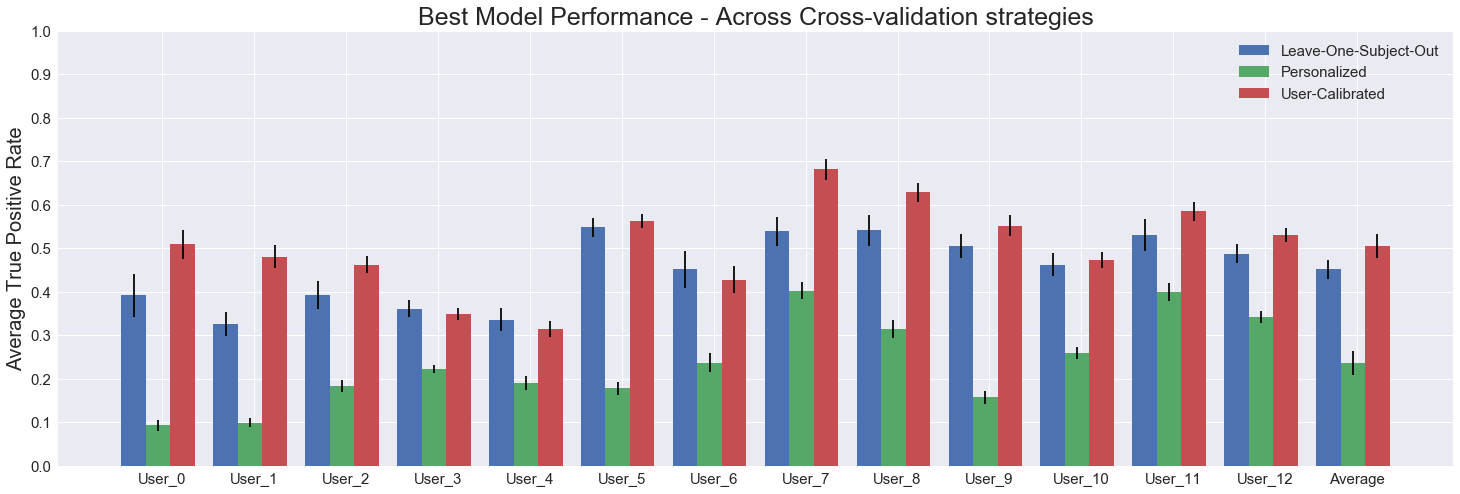

In [10]:
best_model_loso_tpr['cv_strategy'] = 'Leave-One-Subject-Out'
best_model_personalized_tpr['cv_strategy'] = 'Personalized'
best_model_user_calibrated_tpr['cv_strategy'] = 'User-Calibrated'

best_model_tpr = pd.concat([best_model_loso_tpr, best_model_personalized_tpr, best_model_user_calibrated_tpr], 
                           keys=['Leave-One-Subject-Out','Personalized', 'User-Calibrated'])

user_list = ['User_0', 'User_1', 'User_2', 'User_3', 'User_4', 'User_5', 'User_6', 'User_7', 'User_8',
            'User_9', 'User_10', 'User_11', 'User_12', 'Average']
plot_perf(best_model_tpr, user_list, title_text="Best Model Performance - Across Cross-validation strategies",
             file_path = "./figure/BestModel_CV", figsize=(25,8))
best_model_tpr

# Training Curves - Comparison

In [11]:
rf_test_perf = training_curve_user_calibrated(model_path = rf_path+"user_calibrated/rf", model_name = 'Random Forest')
svm_test_perf = training_curve_user_calibrated(model_path = svm_path+"user_calibrated/svm", model_name = 'SVM')
mlp_test_perf = training_curve_user_calibrated(model_path = mlp_path+"user_calibrated/mlp", model_name = 'MLP')

model1_test_perf = training_curve_user_calibrated("./user_split_cv/gest_set_1/split_model_1/Model", model_name='Model 1')
model2_test_perf = training_curve_user_calibrated("./user_split_cv/gest_set_1/split_model_2/Model", model_name='Model 2')
model3_test_perf = training_curve_user_calibrated("./user_split_cv/gest_set_1/split_model_3/Model", model_name='Model 3')
# model4_test_perf = training_curve_user_calibrated("./user_split_cv/gest_set_1/split_model4/Model", model_name='Model 4')

# test_perf_df = pd.concat([rf_test_perf, svm_test_perf, mlp_test_perf, model1_test_perf, model2_test_perf, best_model_test_perf], 
#                          keys=['Random Forest','SVM','MLP','Model 1', 'Model 2', 'Best Model'])

best_test_perf_df = pd.concat([rf_test_perf, model3_test_perf], keys=['Random Forest', 'Model 3'])

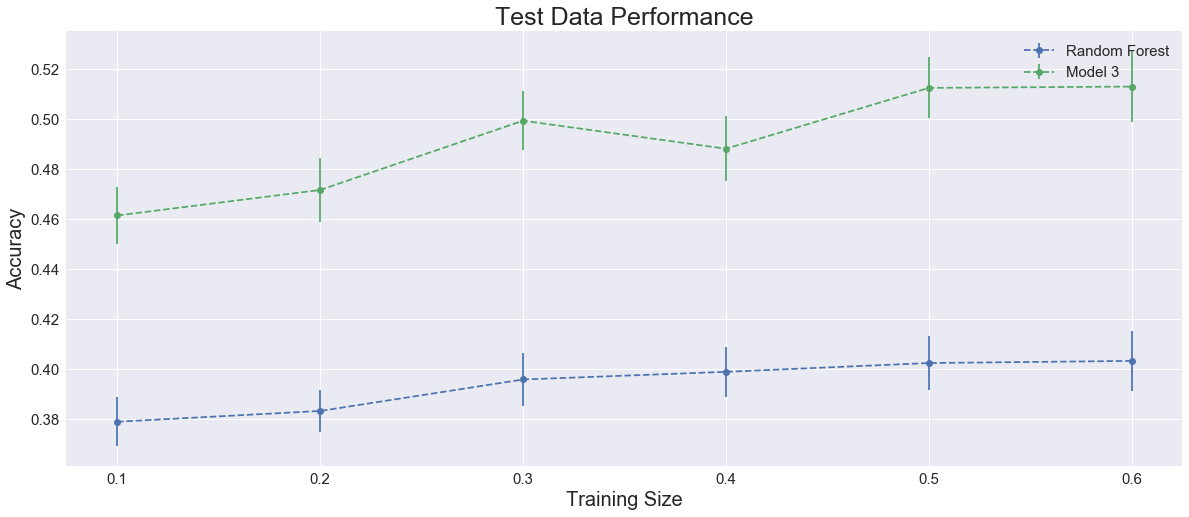

In [12]:
plot_training_curve(best_test_perf_df, title_text="Test Data Performance")

# Reduced Gestures

## Generic Gestures

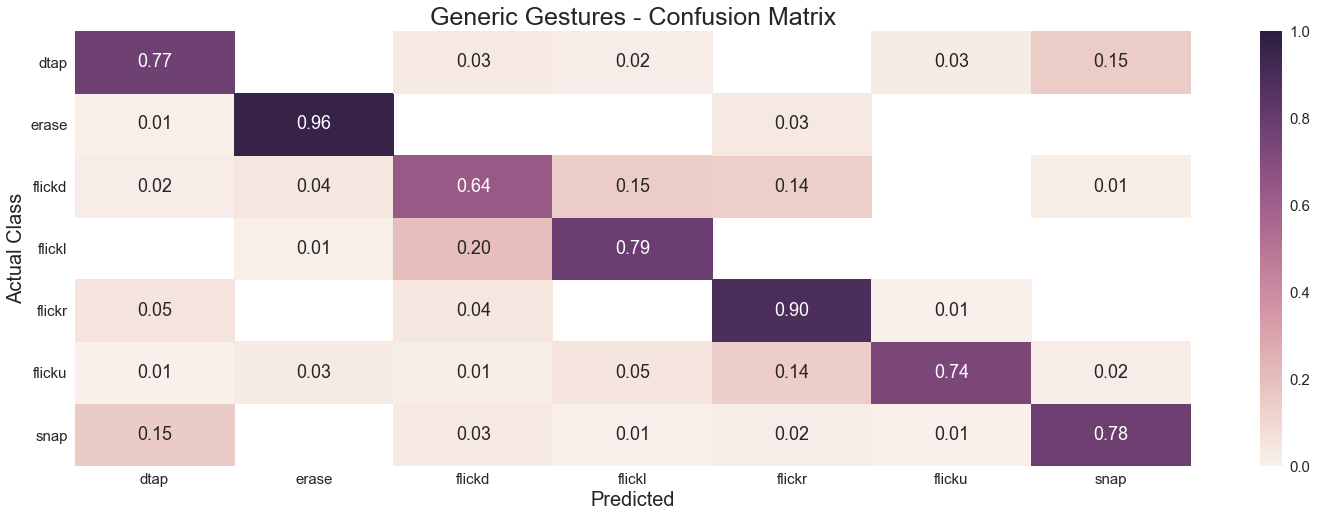

In [13]:
generic_gestures_path = "./user_split_cv/gest_set_2/split_model_3/Model0.6"
class_names = np.load(generic_gestures_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
generic_gesture_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(generic_gestures_path)
generic_gestures_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "Generic Gestures - Confusion Matrix",
                                   file_path = "./figure/Generic_Gestures")

## Simple Gestures

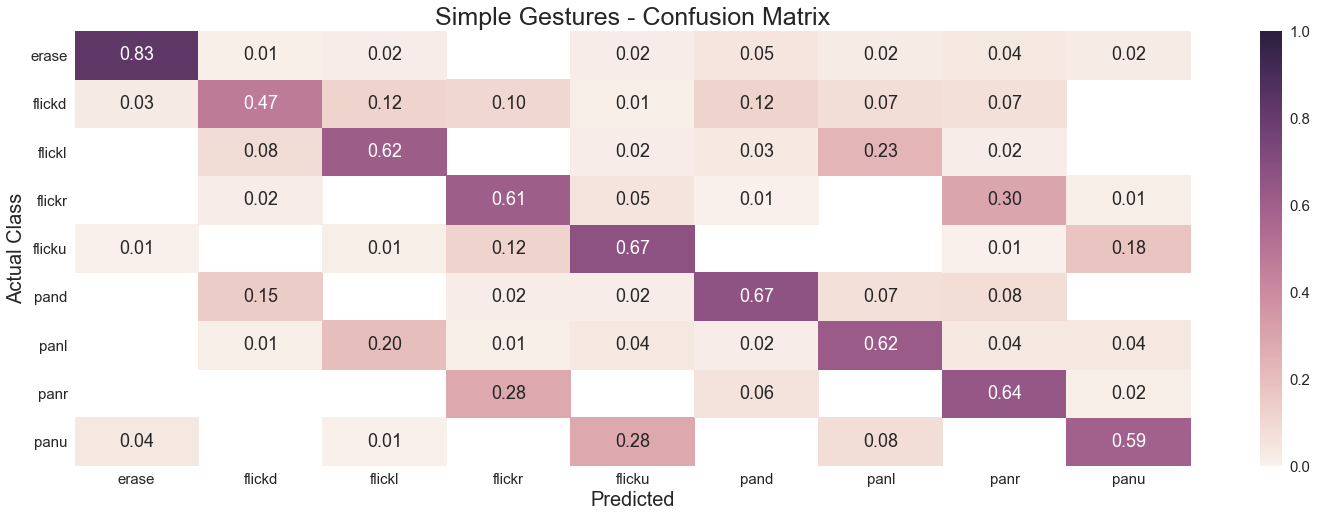

In [14]:
simple_gestures_path = "./user_split_cv/gest_set_3/split_model_3/Model0.6"
class_names = np.load(simple_gestures_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
simple_gesture_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(simple_gestures_path)
simple_gestures_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "Simple Gestures - Confusion Matrix",
                                   file_path = "./figure/Simple_Gestures")

## Mapping Gestures

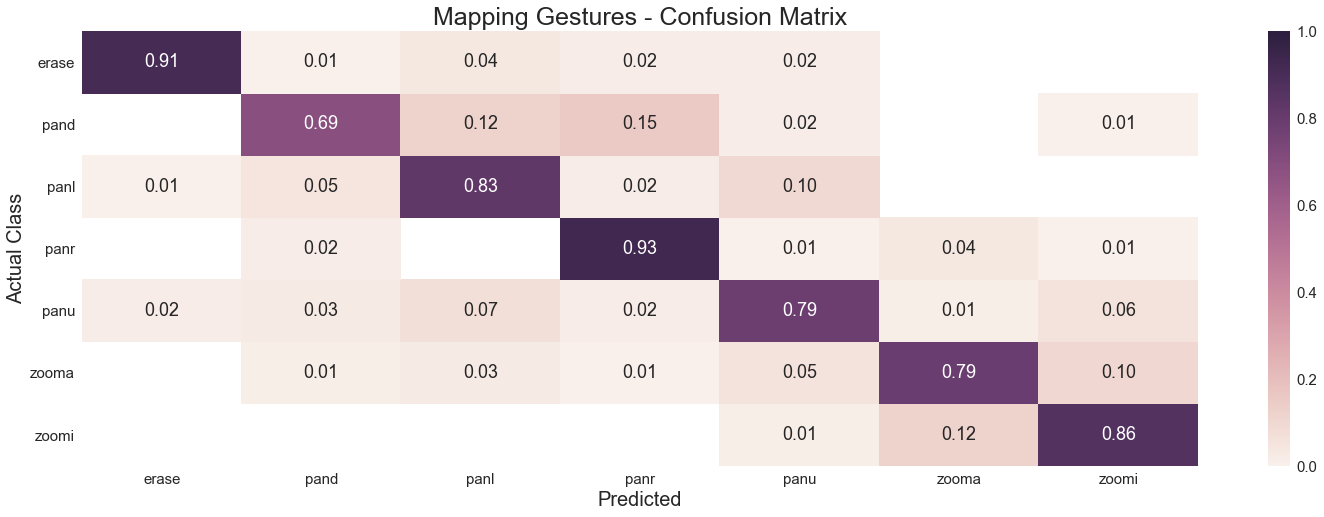

In [15]:
map_gestures_path = "./user_split_cv/gest_set_4/split_model_3/Model0.6"
class_names = np.load(map_gestures_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
mapping_gesture_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(map_gestures_path)
mapping_gestures_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "Mapping Gestures - Confusion Matrix",
                                   file_path = "./figure/Mapping_Gestures")

## Gaming Gestures

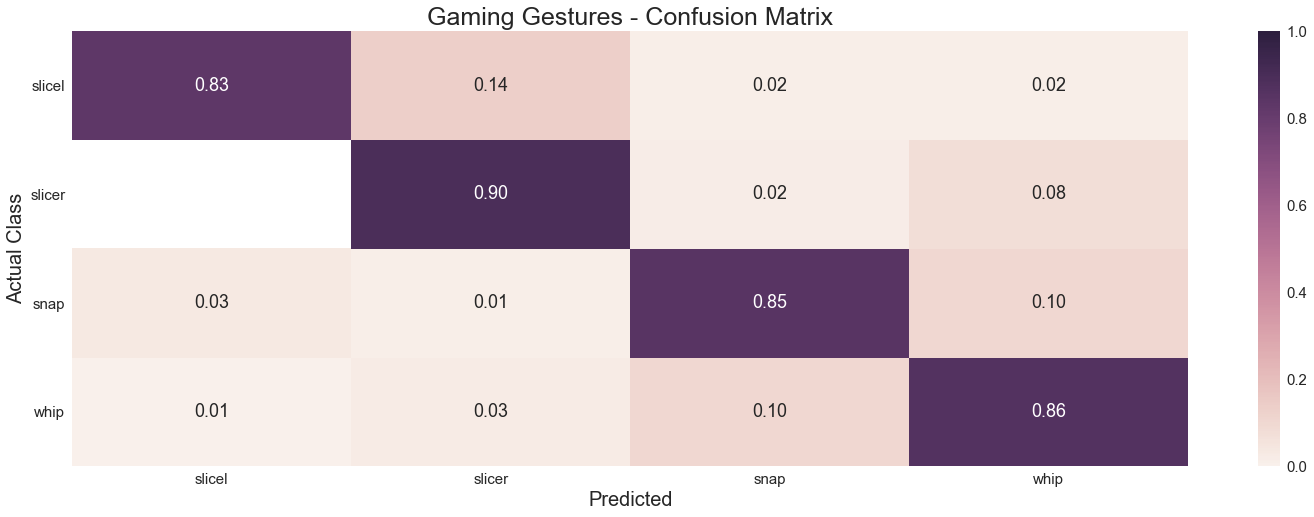

In [16]:
game_gestures_path = "./user_split_cv/gest_set_5/split_model_3/Model0.6"
class_names = np.load(game_gestures_path+"_Class_Names.npz")['arr_0']

# Compute per gesture per user true positive rate
game_gesture_tpr, y_true_flat, y_pred_flat = get_personalized_tpr(game_gestures_path)
game_gestures_perf = classification_report(y_true = flat_list_of_array(y_true_flat),
                                   y_pred = flat_list_of_array(y_pred_flat), 
                                   target_names = class_names,
                                   title_text = "Gaming Gestures - Confusion Matrix",
                                   file_path = "./figure/Gaming_Gestures")

# Comparison across users for Reduced Gesture Set

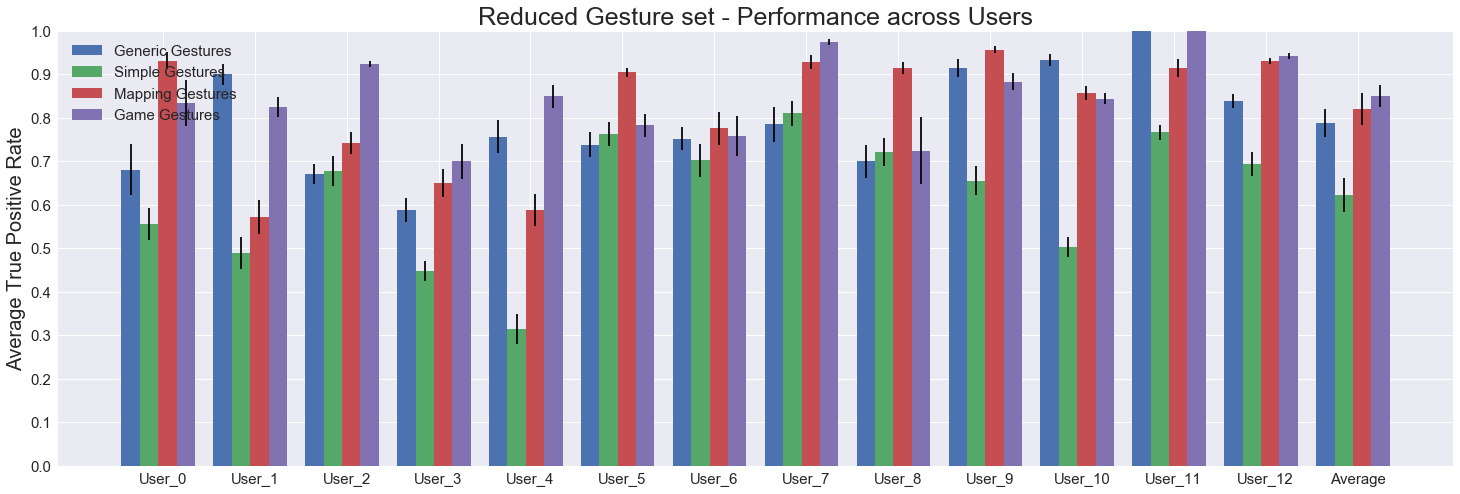

In [17]:
generic_gesture_tpr['Gesture_Set'] = 'Generic Gestures'
simple_gesture_tpr['Gesture_Set'] = 'Simple Gestures'
mapping_gesture_tpr['Gesture_Set'] = 'Mapping Gestures'
game_gesture_tpr['Gesture_Set'] = 'Game Gestures'

best_model_tpr = pd.concat([generic_gesture_tpr, simple_gesture_tpr, mapping_gesture_tpr, game_gesture_tpr], 
                           keys=['Generic Gestures','Simple Gestures','Mapping Gestures','Game Gestures'])

user_list = ['User_0', 'User_1', 'User_2', 'User_3', 'User_4', 'User_5', 'User_6', 'User_7', 'User_8',
            'User_9', 'User_10', 'User_11', 'User_12', 'Average']
plot_perf(best_model_tpr, user_list, title_text="Reduced Gesture set - Performance across Users",
             file_path = "./figure/ReducedGestureSet", figsize=(25,8))

In [18]:
best_model_tpr

0         1         2         3         4  \
Generic Gestures 0  0.680952  0.900000  0.671429  0.588095  0.757143   
                 1  0.058061  0.023905  0.023659  0.028533  0.037070   
Simple Gestures  0  0.555556  0.488889  0.677778  0.448148  0.314815   
                 1  0.037272  0.037493  0.034971  0.023785  0.035292   
Mapping Gestures 0  0.931973  0.571429  0.742857  0.650000  0.587302   
                 1  0.018815  0.039235  0.025441  0.032914  0.036567   
Game Gestures    0  0.833333  0.825000  0.925000  0.700000  0.850000   
                 1  0.052705  0.023385  0.006847  0.041079  0.026220   

                           5         6         7         8         9  \
Generic Gestures 0  0.738095  0.752381  0.785714  0.700000  0.914286   
                 1  0.028386  0.026542  0.040490  0.037253  0.020631   
Simple Gestures  0  0.762434  0.702469  0.811111  0.722222  0.655556   
                 1  0.027008  0.037962  0.028672  0.031731  0.033572   
Mapping Gestures 0  0.904762  0.776190  0.928571  0.914286  0.957143   
                 1  0.010248  0.037940  0.016555  0.013445  0.008706   
Game Gestures    0  0.783333  0.759259  0.975000  0.725000  0.883333   
                 1  0.026141  0.045737  0.006847  0.076784  0.018819   

                          10        11        12  Average across users  \
Generic Gestures 0  0.933333  1.000000  0.838936              0.789259   
                 1  0.014160  0.000000  0.015728              0.032143   
Simple Gestures  0  0.503704  0.766667  0.694420              0.623367   
                 1  0.023458  0.017916  0.027963              0.039457   
Mapping Gestures 0  0.857143  0.914286  0.931127              0.820544   
                 1  0.016924  0.020631  0.006819              0.037253   
Game Gestures    0  0.844444  1.000000  0.942434              0.849703   
                 1  0.012395  0.000000  0.007819              0.024943   

                         Gesture_Set  
Generic Gestures 0  Generic Gestures  
                 1  Generic Gestures  
Simple Gestures  0   Simple Gestures  
                 1   Simple Gestures  
Mapping Gestures 0  Mapping Gestures  
                 1  Mapping Gestures  
Game Gestures    0     Game Gestures  
                 1     Game Gestures